In [61]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

#import sys
#sys.path.append('/volper/users/alayaelm/Documents/git/wasslsp')

from utils import *
from kernels import Kernel

#init_notebook_mode(connected=True) ## plotly init

#import os
#path_data = '/volper/users/alayaelm/Documents/git/wasslsp/data/'



In [62]:
df_hr = pd.read_csv('HRVProcessedData[[Beat]].csv')

In [63]:
df_hr.head(), df_hr.columns, df_hr.shape

(   Unnamed: 0   Time        niHR        RR
 0           1  0.000  182.926773  328.0001
 1           2  0.328  182.926773  328.0001
 2           3  0.716  154.639375  387.9995
 3           4  1.124  147.058679  408.0004
 4           5  1.500  159.574468  376.0000,
 Index(['Unnamed: 0', 'Time', 'niHR', 'RR'], dtype='object'),
 (17178, 4))

In [64]:
df_hr['niHR_scaled'] = df_hr[['niHR']]

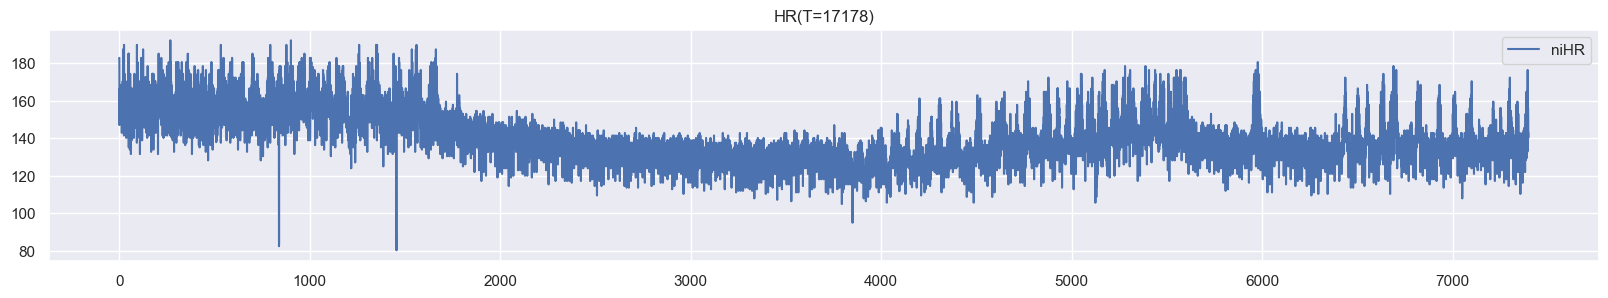

In [65]:
plt.rcParams["figure.figsize"] = (20,3)
#plt.plot(df_hr['Time'], df_hr['niHR'], label="niHR")
plt.plot(df_hr['Time'], df_hr['niHR_scaled'], label="niHR")
plt.legend()
plt.title("HR(T=17178)")
plt.show()

## Nadarawatson estimator 

In [66]:
C = 2
space_kernel = "gaussian" # "silverman"
time_kernel = "uniform"
T = df_hr.shape[0]
d = 1
bandwidth = T **(-0.4 / (d+1)) / C
X_dict = df_hr['niHR'].values.reshape(-1,1) #df_malleco['Value'].diff().values.reshape(-1, 1)
X_tvar_2 = df_hr['niHR'].values #df_malleco['Value'].diff().values

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 
Y_t_T = df_hr['niHR'].values

weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict, t)
    
m_hat= [np.sum(weights[str(t)] * Y_t_T) for t in range(T)]

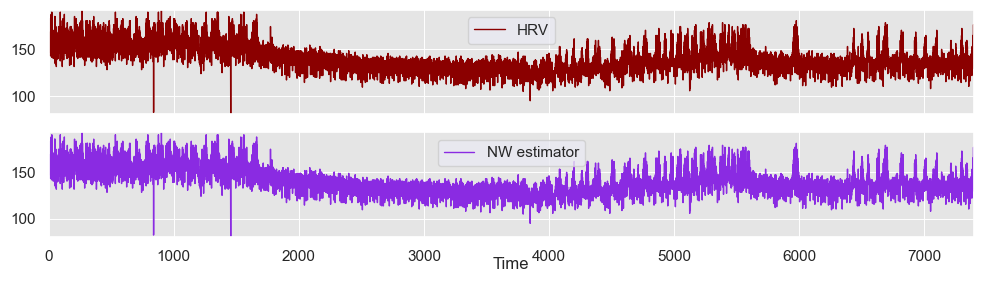

2024/10/22 22:58:23 Saved result in file HRV-NW-Gaussian-sp-Uniform-time-C-2.pdf


In [67]:
import logging

sns.set(style="darkgrid")

logging.basicConfig(
    format="%(asctime)s %(message)s", datefmt="%Y/%m/%d %H:%M:%S", level=logging.INFO
)

path_fig = "D:/ExperimentsPhD/October-22-24/wasslsp/notebooks/clean-real"

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,3) , sharex=True)
plt.subplots_adjust(wspace=0, hspace=0.02)

output_filename = "HRV-NW-Gaussian-sp-Uniform-time-C-2.pdf"

for axis in ax:
    axis.grid(True, which='major', linestyle='-', linewidth=.7, color='white')  
    #axis.grid(True, which='minor', linestyle=':', linewidth=0.5, color='lightgray')  
    axis.set_facecolor('#E5E5E5')  
    axis.minorticks_on()  


ax[0].plot(df_hr['Time'].values, X_tvar_2, lw=1, label="HRV", color="darkred")  # #, color="r") #, cmap=cm)
ax[0].set_xlim(min(df_hr['Time'].values), max(df_hr['Time'].values))
ax[0].set_ylim(min(min(m_hat), min(X_tvar_2)),  max(max(m_hat), max(X_tvar_2)))
ax[0].legend(loc='upper center')
#ax[0].grid(True)

ax[1].plot(df_hr['Time'].values, np.array(m_hat), lw=1, label="NW estimator" , c="blueviolet")#cm_bright[0]) #"orange")
ax[1].set_xlim(min(df_hr['Time'].values), max(df_hr['Time'].values))
ax[1].set_ylim(min(min(m_hat), min(X_tvar_2)),  max(max(m_hat), max(X_tvar_2)))
ax[1].legend(loc='upper center')
ax[1].set_xlabel("Time")
ax[1].xaxis.set_label_coords(0.5, -0.19)
#ax[1].grid(True)

plt.savefig(path_fig+output_filename, dpi=300)
plt.tight_layout()
plt.show()
logging.info("Saved result in file %s" % output_filename)

In [68]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

np.sqrt(mse(np.array(m_hat), X_tvar_2)), mae(np.array(m_hat), X_tvar_2)

(0.000661267988400133, 4.039687177162301e-05)

# NW Conditional CDF

In [69]:
def replication_HRV(data=None, sigma=1., d=1, n_replications=1):
    """
    Replication genearating procedure of HRV data
    """
    T = data.shape[0]
    
    X_tvar_2 = np.zeros(T)
    X_tvar_2_replications = np.zeros((n_replications, T))

    X_dict = {}
    for replication in range(n_replications):
        t = 1
        epsilon = np.random.normal(size=(T), scale=sigma)
        X = np.zeros((T,d))
        while t <= T-1 :
            X_tvar_2[t] = df_hr['niHR_scaled'].values[t] + epsilon[t]
            X[t] = [X_tvar_2[t-1]]
            t += 1
        
        X_dict[str(replication)] = X
        X_tvar_2_replications[replication] = X_tvar_2
        
    return X_tvar_2_replications

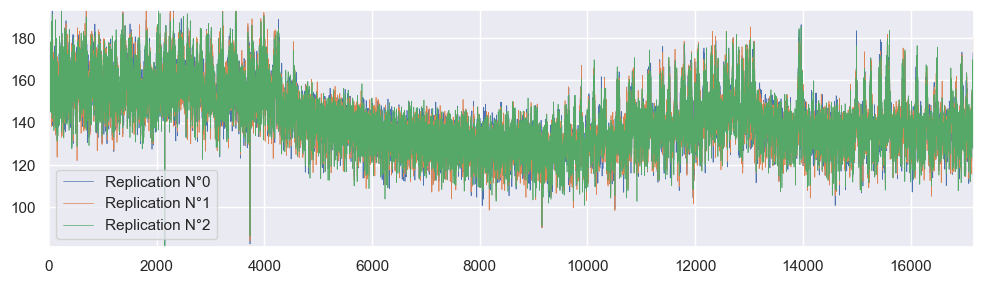

In [70]:
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)
sigma = 4.
n_replications = 3

X_tvar_2_replications = replication_HRV(
    data=df_hr['niHR'], sigma=sigma, n_replications=n_replications
)

for replication in range(n_replications):
    plt.plot(X_tvar_2_replications[replication], lw=.5, label='Replication N°' f'{replication}')
    plt.ylim(min(X_tvar_2_replications[replication][1:,]), max(X_tvar_2_replications[replication]))
    plt.xlim(0, T)
    
    plt.grid(True)
    plt.legend()
    
plt.tight_layout()
plt.savefig(f"3 replications of HRV dataset sigma={sigma}.pdf", dpi=300)
plt.show()

In [71]:
times_t = [7750, 8000, 8250, 8500, 8750, 9000, 9250, 9500]
times_T = [T]
n_replications = 3
d = 1

In [72]:
T = df_hr['niHR'].shape[0]

In [73]:
xi = 0.4 / (2*(d+1))
lambda_ = 1/12
T = df_hr['niHR'].shape[0]
bandwidth = lambda_ * ( T **(-xi) )
uvals = np.array(times_t) / T
uvals

array([0.45115846, 0.46571196, 0.48026546, 0.49481895, 0.50937245,
       0.52392595, 0.53847945, 0.55303295])

In [74]:
mask = []
for val in uvals:
    bool_ = (val >= bandwidth) and (val <= 1-bandwidth)
    mask.append(bool_)

In [75]:
mask

[True, True, True, True, True, True, True, True]

In [76]:
[(val >= bandwidth) and (val <= 1-bandwidth) for val in uvals ]

[True, True, True, True, True, True, True, True]

In [77]:
X_tvar_2 = {}
X_tvar_2_replications = {}
X_dict = {}

# "T:"+str(T
for T in times_T:
    X_tvar_2_replications[f"T:{T}"] = np.zeros((n_replications, T))
    X_dict[f"T:{T}"] = {}

In [78]:
import scipy as scp
import matplotlib
from matplotlib import cm
from scipy.stats import wasserstein_distance

In [79]:
for T in times_T:
    u_var = np.linspace(0., 1., T)

    for replication in range(n_replications):
        t = 1
        epsilon = np.random.normal(size=T, scale=sigma)
        X = np.zeros((T,d))
        X_tvar_2_T = np.zeros(T)
        while t <= T-1 :
            X_tvar_2_T[t] = df_hr['niHR'].values[t] + epsilon[t]
            X[t] = [X_tvar_2_T[t-1]]
            t += 1

        X_tvar_2_replications[f"T:{T}"][replication] = X_tvar_2_T
        X_dict[f"T:{T}"][str(replication)] = X


In [80]:
X_tvar_2 = {}

for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = {}


In [81]:
for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = []


for t in times_t:
    for replication in range(n_replications):
        for T in times_T:
            z = X_tvar_2_replications[f"T:{T}"][replication][t-1]
            X_tvar_2[f"t:{t}_T:{T}"].append(z)

for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = np.array(X_tvar_2[f"t:{t}_T:{T}"])

In [82]:
norm_X_tvar_2 = {}
for t in times_t:
    for T in times_T:
        norm_X_tvar_2[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_T:{T}"])

# space_kernel = "gaussian"; time_kernel = "uniform"

In [83]:
space_kernel = "gaussian" #"silverman"
time_kernel = "uniform" #"tricube"
xi = 0.4 / (2*(d+1))
lambda_ = 1/12
bandwidth = lambda_ * ( T **(-xi) )

gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for T in times_T:
        gaussian_weights[f"t:{t}_T:{T}"] = {}
    
for T in times_T:
    bandwidth = lambda_ * ( T **(-xi) )
    gaussian_kernel[f"T:{T}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)

In [84]:
gaussian_kernel

{'T:17178': Kernel(T=17178, bandwidth=0.03142834371256549, time_kernel='uniform')}

In [85]:
n_replications = 3
for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            gaussian_weights[f"t:{t}_T:{T}"][str(replication)] = \
            gaussian_kernel[f"T:{T}"].fit(X_dict[f"T:{T}"][str(replication)], t)

In [86]:
gaussian_weights_tensor =  {} 

for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):
        gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"] = {}

times_T = [T]
for i_t in range(len(times_t)):
    for i_T in range(len(times_T)): 
        for replication in range(n_replications):
            gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)] =\
            gaussian_weights[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)]

In [87]:
empirical_cds = {}
for t in times_t:
    for T in times_T:
        empirical_cds[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_T:{T}"])


In [88]:
def eval_univariate(x, weights):
        """Inner function for ECDF of one variable."""
        sorter = x.argsort()
        x = x[sorter]
        weights = weights[sorter]
        y = weights.cumsum()

        # if self.stat in ["percent", "proportion"]:
        y = y / y.max()
        # if self.stat == "percent":
            # y = y * 100

        # x = np.r_[-np.inf, x]
        # y = np.r_[0, y]
        x = np.r_[x]
        y = np.r_[y]

        # if self.complementary:
            # y = y.max() - y

        return y, x

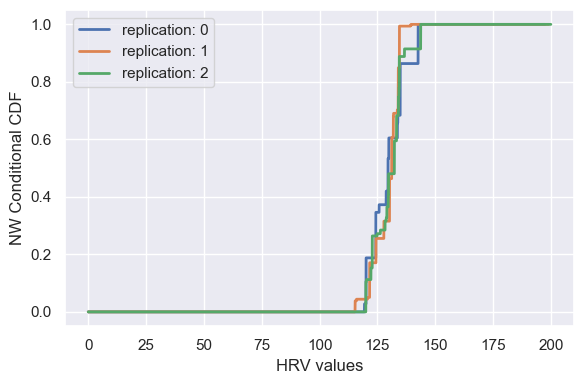

In [94]:
x_rep = {} 
y_rep = {} 
t_values_new = [9000]
wasserstein_distances = {}

for t in t_values_new:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications): 
    for t in t_values_new:
        for T in times_T:
            y, x = eval_univariate(
                X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            plt.rcParams["figure.figsize"] = (6,4)
            plt.plot(x, y, label=f"replication: {replication}", lw=2)# _replication:{replication}")
            plt.xlabel("HRV values")
            plt.ylabel("NW Conditional CDF")
            plt.grid(True)
            plt.legend()
plt.tight_layout()
plt.savefig("3 NW estimators of L=3 replications HRV.png")

In [90]:
x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance


In [91]:
wass_distances_all_replications = {}

for t in times_t:
    for T in times_T:
        wass_distances_all_replications[f"t:{t}_T:{T}"] = []

for t in times_t:
    for T in times_T:       
        for replications in range(n_replications):
            wass_distances_all_replications[f"t:{t}_T:{T}"].append(wasserstein_distances[f"t:{t}_T:{T}"][str(replication)])
        

In [92]:
plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for T in times_T:
        wass_distances_empirical_meanNW[f"t:{t}_T:{T}"] = wasserstein_distance(
            empirical_cds[f"t:{t}_T:{T}"], y_rep[f"t:{t}_T:{T}"].mean(axis=0)
        )

In [93]:
wass_distances_empirical_meanNW

{'t:7750_T:17178': 0.20483729478352872,
 't:8000_T:17178': 0.11939432933032093,
 't:8250_T:17178': 0.19784971083926753,
 't:8500_T:17178': 0.1564503457611433,
 't:8750_T:17178': 0.19881295422178172,
 't:9000_T:17178': 0.22069403675998994,
 't:9250_T:17178': 0.16322883248937078,
 't:9500_T:17178': 0.12482958882618425}